## Lab6-Assignment: Topic Classification

Use the same training, development, and test partitions of the the 20 newsgroups text dataset as in Lab6.4-Topic-classification-BERT.ipynb 

* Fine-tune and examine the performance of another transformer-based pretrained language models, e.g., RoBERTa, XLNet

* Compare the performance of this model to the results achieved in Lab6.4-Topic-classification-BERT.ipynb and to a conventional machine learning approach (e.g., SVM, Naive Bayes) using bag-of-words or other engineered features of your choice. 
Describe the differences in performance in terms of Precision, Recall, and F1-score evaluation metrics.

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
)
from sklearn.metrics import classification_report
from tqdm import tqdm
import pandas as pd

from sklearn.datasets import fetch_20newsgroups

### importing dataset of 20 newsgroups with 18K posts on 20 topics

In [2]:
# load only a sub-selection of the categories (4 in our case)
categories = ["alt.atheism", "comp.graphics", "sci.med", "sci.space"]

# remove the headers, footers and quotes (to avoid overfitting)
newsgroups_train = fetch_20newsgroups(
    subset="train",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)
newsgroups_test = fetch_20newsgroups(
    subset="test",
    remove=("headers", "footers", "quotes"),
    categories=categories,
    random_state=42,
)

from collections import Counter

Counter(newsgroups_train.target)

train = pd.DataFrame({"text": newsgroups_train.data, "labels": newsgroups_train.target})
test = pd.DataFrame({"text": newsgroups_test.data, "labels": newsgroups_test.target})

# Data Exploration

In [3]:
Counter(newsgroups_train.target)

Counter({2: 594, 3: 593, 1: 584, 0: 480})

In [4]:
Counter(newsgroups_test.target)

Counter({2: 396, 3: 394, 1: 389, 0: 319})

### converting to pandas dataframe

In [5]:
train = pd.DataFrame({'text': newsgroups_train.data, 'labels': newsgroups_train.target})

In [6]:
print(len(train))
train.head(5)

2251


,text,labels
0,WHile we are on the subject of the shuttle sof...,3
1,There is a program called Graphic Workshop you...,1
2,,2
3,My girlfriend is in pain from kidney stones. S...,2
4,I think that's the correct spelling..\n\tI am ...,2


In [7]:
test = pd.DataFrame({"text": newsgroups_test.data, "labels": newsgroups_test.target})

In [8]:
print(len(test))
test.head(5)

1498


,text,labels
0,\nAnd guess who's here in your place.\n\nPleas...,1
1,Does anyone know if any of Currier and Ives et...,1
2,=FLAME ON\n=\n=Reading through the posts about...,2
3,\nBut in this case I said I hoped that BCCI wa...,0
4,\nIn the kind I have made I used a Lite sour c...,2


### Development Set

In [ ]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(
    train, test_size=0.1, random_state=0, stratify=train[["labels"]]
)

In [10]:
print(len(train))
print("train:", train[["labels"]].value_counts(sort=False))
train.head(3)

2025
train: labels
0         432
1         525
2         534
3         534
Name: count, dtype: int64


,text,labels
559,I wonder how many atheists out there care to s...,0
2060,We are interested in purchasing a grayscale pr...,1
1206,"Dear Binary Newsers,\n\nI am looking for Quick...",1


In [11]:
print(len(dev))
print("dev:", dev[["labels"]].value_counts(sort=False))
dev.head(3)

226
dev: labels
0         48
1         59
2         60
3         59
Name: count, dtype: int64


,text,labels
1570,I'd dump him. Rude is rude and it seems he en...,2
1761,Hi Everyone ::\n\nI am looking for some soft...,1
455,A friend of mine has been diagnosed with Psori...,2


# RoBERTa model

In [12]:
# Load pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Tokenize and preprocess the data
train_texts = train["text"].tolist()
train_labels = train["labels"].tolist()
dev_texts = dev["text"].tolist()
dev_labels = dev["labels"].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True, max_length=128)

train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels),
)
dev_dataset = TensorDataset(
    torch.tensor(dev_encodings["input_ids"]),
    torch.tensor(dev_encodings["attention_mask"]),
    torch.tensor(dev_labels),
)

# Define training parameters
batch_size = 32
epochs = 1
learning_rate = 5e-5
warmup_steps = 0.1 * len(train_dataset) / batch_size
logging_steps = 100
eval_steps = 500
early_stopping_patience = 2

# Create DataLoader for training and validation
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler, batch_size=batch_size
)
dev_sampler = SequentialSampler(dev_dataset)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=len(train_dataloader) * epochs,
)

# Define early stopping variables
best_dev_loss = float("inf")
early_stopping_counter = 0

# Training

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define logging steps
logging_steps = 2

# Lists to store training loss history
train_loss_history = []

# Fine-tune the model
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    progress_bar = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), desc="Training"
    )

    for step, batch in progress_bar:
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()

        if (step + 1) % logging_steps == 0:
            avg_loss = total_loss / logging_steps
            print(avg_loss)
            print(
                f"Step {step + 1}/{len(train_dataloader)}, Average Loss: {avg_loss:.4f}"
            )
            total_loss = 0

            # Store training loss in history
            train_loss_history.append(avg_loss)

    if early_stopping_counter >= early_stopping_patience:
        break

Epoch 1/1


Training:  16%|█▌        | 10/64 [00:41<03:36,  4.01s/it]

0.339706027507782
Step 10/64, Average Loss: 0.3397


Training:  31%|███▏      | 20/64 [01:21<02:59,  4.09s/it]

0.3081608682870865
Step 20/64, Average Loss: 0.3082


Training:  47%|████▋     | 30/64 [02:00<02:12,  3.90s/it]

0.3423848196864128
Step 30/64, Average Loss: 0.3424


Training:  62%|██████▎   | 40/64 [02:44<01:39,  4.16s/it]

0.2756063506007195
Step 40/64, Average Loss: 0.2756


Training:  78%|███████▊  | 50/64 [03:22<00:53,  3.80s/it]

0.35037148743867874
Step 50/64, Average Loss: 0.3504


Training:  94%|█████████▍| 60/64 [04:01<00:15,  3.87s/it]

0.37756619304418565
Step 60/64, Average Loss: 0.3776


Training: 100%|██████████| 64/64 [04:14<00:00,  3.97s/it]


In [22]:
print(train_loss_history)

[0.339706027507782, 0.3081608682870865, 0.3423848196864128, 0.2756063506007195, 0.35037148743867874, 0.37756619304418565]


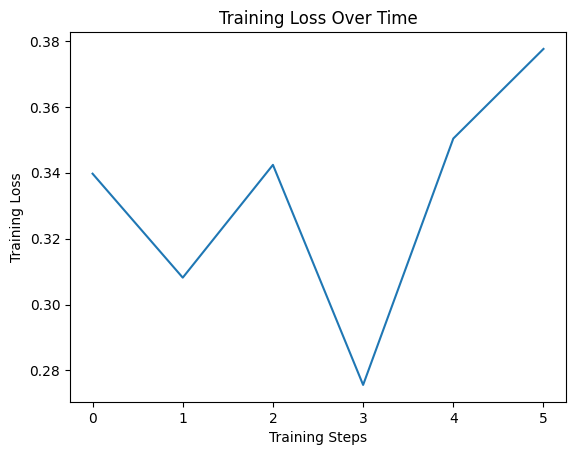

In [23]:
# Plot training loss history
plt.plot(train_loss_history)
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Time")
plt.show()

# Evaluation

In [20]:
# Evaluate the fine-tuned model on the test set
test_texts = test["text"].tolist()
test_labels = test["labels"].tolist()

test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(test_labels),
)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

model.eval()
test_preds = []
test_labels = []

for batch in test_dataloader:
    input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).tolist()

    test_preds.extend(preds)
    test_labels.extend(labels.tolist())

# Print classification report for the test set
print("Test set evaluation:")
print(classification_report(test_labels, test_preds))

Test set evaluation:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       319
           1       0.85      0.92      0.89       389
           2       0.89      0.86      0.88       396
           3       0.82      0.77      0.79       394

    accuracy                           0.84      1498
   macro avg       0.84      0.84      0.84      1498
weighted avg       0.84      0.84      0.84      1498



# END

